الإعداد وقراءة البيانات

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


In [76]:
# قراءة البيانات
df = pd.read_csv("insurance.csv")



In [77]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [78]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [79]:
# عرض معلومات أولية
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [80]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

 تقسيم البيانات - train_test_split

In [81]:
X = df.drop("charges", axis=1)
y = df["charges"]

# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


المعالجة المسبقة - OneHotEncoding + Scaling

In [82]:
# الأعمدة الفئوية
categorical_features = ['sex', 'smoker', 'region']
# الأعمدة الرقمية
numeric_features = ['age', 'bmi', 'children']

# المعالجات
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
numeric_transformer = StandardScaler()

# دمج المعالجات في ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


 الخطوة 4: إنشاء نماذج مختلفة للتحقق من underfitting و overfitting باستخدام Polynomial Regression

In [83]:
train_errors = []
test_errors = []
degrees = range(1, 6)  # درجة متعددة الحدود من 1 إلى 5

for d in degrees:
    model = Pipeline([
        ('preprocess', preprocessor),
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('regressor', LinearRegression())
    ])
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))


رسم الخطأ مقابل درجة الـ Polynomial
python



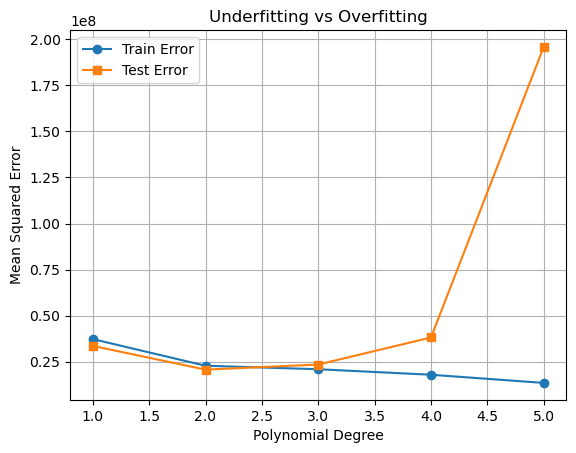

In [84]:
plt.plot(degrees, train_errors, label='Train Error', marker='o')
plt.plot(degrees, test_errors, label='Test Error', marker='s')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Underfitting vs Overfitting')
plt.legend()
plt.grid(True)
plt.show()


الخطوة 5: استخدام Cross-Validation لاختبار أداء النموذج

In [85]:
model_cv = Pipeline([
    ('preprocess', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # درجة مناسبة من الرسم السابق
    ('regressor', LinearRegression())
])

scores = cross_val_score(model_cv, X, y, scoring='r2', cv=5)
print("Cross-Validation R2 Scores:", scores)
print("Average R2:", np.mean(scores))


Cross-Validation R2 Scores: [0.85083108 0.79510478 0.88152939 0.81692    0.83280027]
Average R2: 0.8354371027722907


 الخطوة 6: استخدام Ridge Regression لتقليل Overfitting

In [86]:
model_ridge = Pipeline([
    ('preprocess', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=1.0))
])

model_ridge.fit(X_train, y_train)
y_test_pred = model_ridge.predict(X_test)
print("R2 Score with Ridge:", r2_score(y_test, y_test_pred))


R2 Score with Ridge: 0.866635757837292


الخطوة 7: اختيار أفضل Alpha باستخدام GridSearchCV

In [87]:
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

grid_model = Pipeline([
    ('preprocess', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge())
])

grid_search = GridSearchCV(grid_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best R2 from CV:", grid_search.best_score_)


Best alpha: {'ridge__alpha': 1}
Best R2 from CV: 0.8269717417455368


 الخطوة 8: تقييم النموذج النهائي

Final R2 on Test Set: 0.866635757837292
Final MSE on Test Set: 20704629.42212212


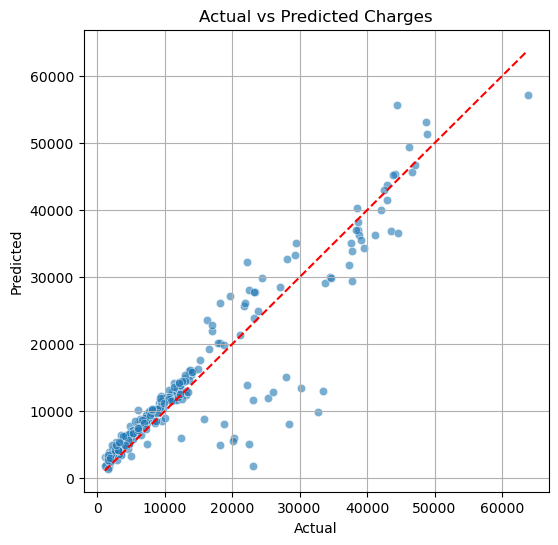

In [ ]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

print("Final R2 on Test Set:", r2_score(y_test, y_test_pred))
print("Final MSE on Test Set:", mean_squared_error(y_test, y_test_pred))

# رسم Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Charges")
plt.grid(True)
plt.savefig("outputs/plots/actual_vs_predicted_charges.png")

plt.show()


In [89]:
import pandas as pd

# بيانات جديدة خامة بنفس الأعمدة
test_data = pd.DataFrame({
    'age': [30],
    'sex': ['male'],
    'bmi': [29.5],
    'children': [0],
    'smoker': ['no'],
    'region': ['southeast']
})

# التوقع باستخدام النموذج المدرب كاملاً (بما فيه preprocessing و polynomial)
predicted_cost = best_model.predict(test_data)[0]

print(" التكلفة المتوقعة بالدولار:", predicted_cost)
print(" التكلفة بالريال اليمني:", f"{predicted_cost * 600:,.0f} ريال")


 التكلفة المتوقعة بالدولار: 5163.383594859152
 التكلفة بالريال اليمني: 3,098,030 ريال


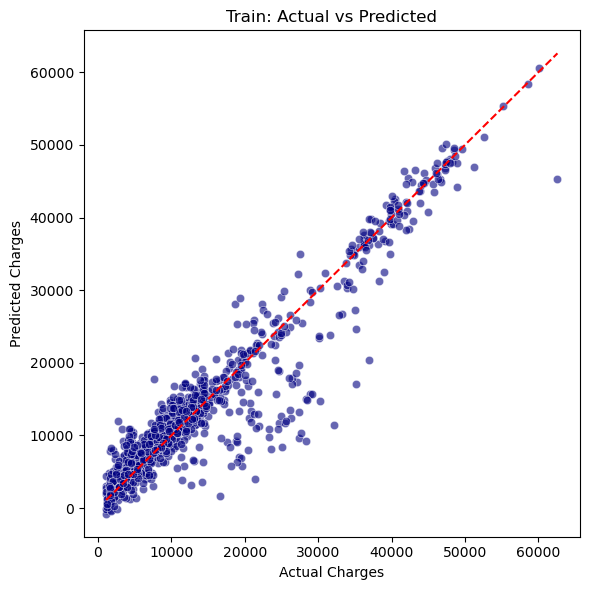

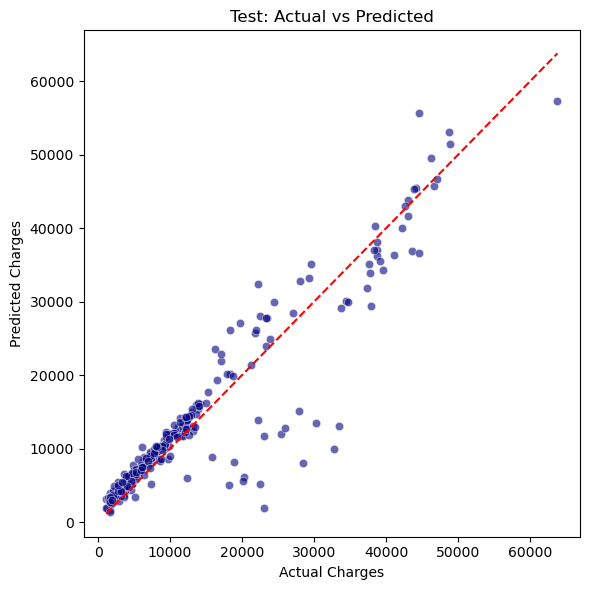

In [90]:
def plot_actual_vs_pred(y_true, y_pred, title, filename):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, color='navy')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"outputs/plots/{filename}")
    plt.show()
    

# تطبيق على بيانات التدريب والاختبار:
plot_actual_vs_pred(y_train, y_train_pred, "Train: Actual vs Predicted", "train_actual_vs_pred.png")
plot_actual_vs_pred(y_test, y_test_pred, "Test: Actual vs Predicted", "test_actual_vs_pred.png")




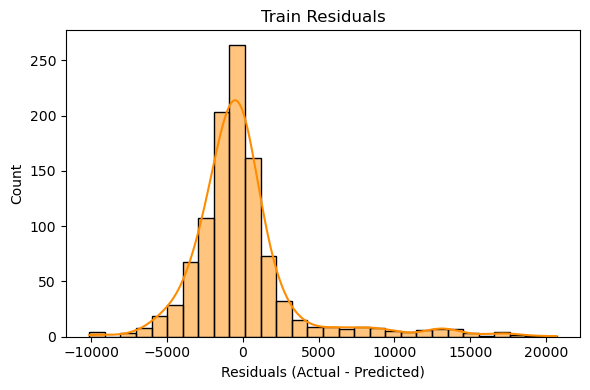

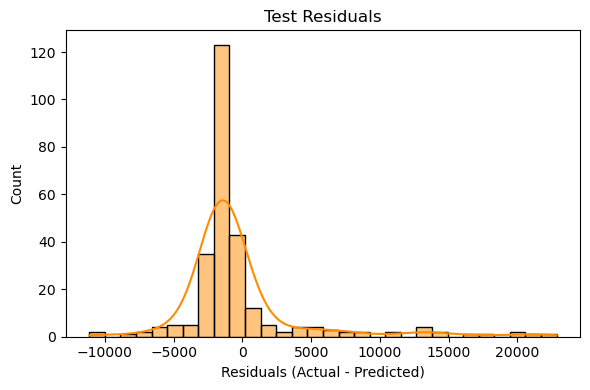

In [91]:

def plot_residuals(y_true, y_pred, title, filename):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True, color='darkorange')
    plt.title(title)
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"outputs/plots/{filename}")
    plt.show()
plot_residuals(y_train, y_train_pred, "Train Residuals", "train_residuals.png")
plot_residuals(y_test, y_test_pred, "Test Residuals", "test_residuals.png")


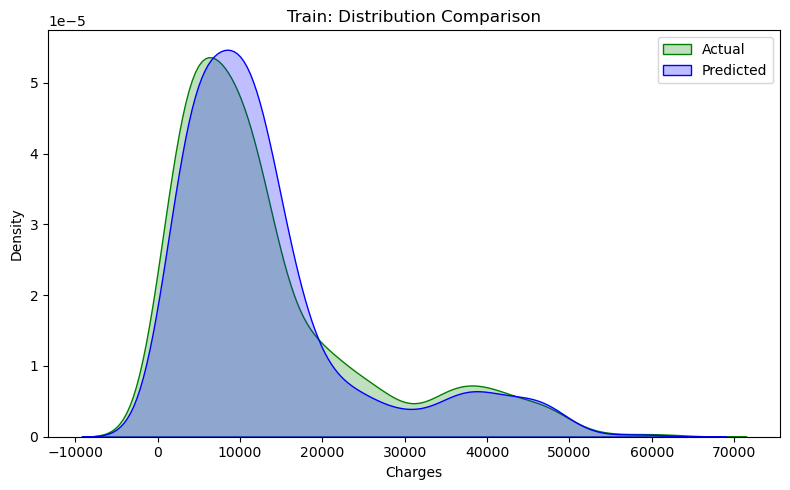

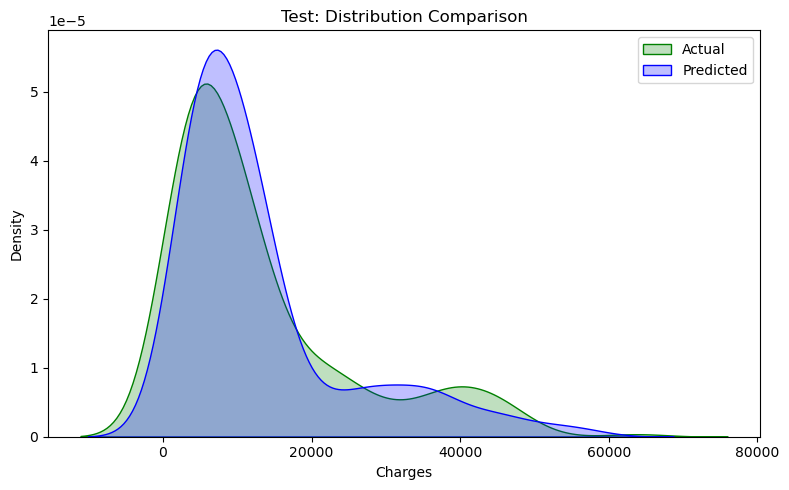

In [92]:
def plot_distribution_comparison(y_true, y_pred, title, filename):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(y_true, label='Actual', fill=True, color='green')
    sns.kdeplot(y_pred, label='Predicted', fill=True, color='blue')
    plt.title(title)
    plt.xlabel("Charges")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/plots/{filename}")
    plt.show()

plot_distribution_comparison(y_train, y_train_pred, "Train: Distribution Comparison", "train_distribution_comparison.png")
plot_distribution_comparison(y_test, y_test_pred, "Test: Distribution Comparison", "test_distribution_comparison.png")

In [95]:



joblib.dump(grid_search.best_estimator_, 'outputs/model_joblib.pkl')



['outputs/model_joblib.pkl']